In [19]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
#import category_encoders as ce
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import iqr,skew 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,cross_val_predict,KFold, StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,PowerTransformer
from sklearn.linear_model import LogisticRegression,BayesianRidge,Lasso
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, f_classif,RFECV,SelectKBest,chi2,mutual_info_classif,SelectFromModel
from sklearn.pipeline import Pipeline,make_pipeline
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS,SequentialFeatureSelector as SFS
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler,BorderlineSMOTE,SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import  Pipeline as Imb_pipeline
import pickle

import time
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns',15)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [55]:
#Importing Data sets
file_path='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/processed/'

loan_train_prepro=pd.read_pickle(file_path+ 'loan_train_prepro.pkl')
loan_test_prepro=pd.read_pickle(file_path+ 'loan_test_prepro.pkl')

In [56]:
loan_train_prepro.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Total_Income',
       'Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y'],
      dtype='object')

In [62]:
y=loan_train_prepro.Loan_Status_Y
X=loan_train_prepro[['Loan_Amount_Term', 'Credit_History','Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes','Dependents_1', 
                     'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes','Property_Area_Semiurban', 
                     'Property_Area_Urban', 'Loan_Status_Y']].copy()
X.drop(['Loan_Status_Y'],axis=1,inplace=True)

Since we have seen that the proportion of the approved class is significantly higher than the rejected class, we will apply a stratifield-kfold to keep the proportion in the splits.

In [22]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42) 
#Creating a dataframe to store the results we are obtaining after applying different methods and alternatives. 
Results=pd.DataFrame(columns=['Algorithm', 'Model', 'Features','Best_Score_train','Best_Score_test','Case','Case_Descript'])

##### 3.1 Baseline: No Hyperparameter tuning, no Feature Engineering, no Feature Selection

In [23]:
#Algorithms
alg1=LogisticRegression()
alg2= SVC(probability=True)
alg3=KNeighborsClassifier()
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()

#Scaling the features for the logistic regression, SVC, KNeighbor and xgb. No need to scale for the tree based algorithms
pipe1 = Pipeline([('std', StandardScaler()),('classifier', alg1)])
pipe2 = Pipeline([('std', StandardScaler()),('classifier', alg2)])
pipe3 = Pipeline([('std', StandardScaler()),('classifier', alg3)])
pipe4 = Pipeline([('classifier', alg4)])
pipe5 = Pipeline([('classifier', alg5)])
pipe6 = Pipeline([('std', StandardScaler()),('classifier', alg6)])

pipelist= [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6]

In [24]:
for i,j in zip(pipelist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
     results_kfold = cross_validate(i, X, y, cv=kf,return_train_score=True,scoring='accuracy')
     Results.loc[len(Results)] = [j, results_kfold,'All original features',results_kfold['train_score'].mean(),
                                  results_kfold['test_score'].mean(),'Algorithm only','Original features. Log transform. No tunning, \
                                  No feature selection']

In [25]:
Results

Algorithm                                              Model  \
0    Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1       SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2       KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3     DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4        RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5       XGB  {'fit_time': [0.04983019828796387, 0.053163528...   

                Features  Best_Score_train  Best_Score_test            Case  \
0  All original features           0.80981          0.80807  Algorithm only   
1  All original features           0.82067          0.80648  Algorithm only   
2  All original features           0.81940          0.76073  Algorithm only   
3  All original features           1.00000          0.69383  Algorithm only   
4  All original features           0.98860          0.74296  Algorithm only   
5  All original features           0.86193          0.80325  Algorithm only   

                                       Case_Descript  
0  Original features. Log transform. No tunning, ...  
1  Original features. Log transform. No tunning, ...  
2  Original features. Log transform. No tunning, ...  
3  Original features. Log transform. No tunning, ...  
4  Original features. Log transform. No tunning, ...  
5  Original features. Log transform. No tunning, ...

Model with best test scores are Logreg, SVM and XGB. It also can be appreciated how Decission Tree and Random Forest tend to overfit (tran score are 100% and 98% while test scores are 69% and 74%). Next we will do a GridSearch to fine tune the algorithms parameters.

##### 3.2 Model with Hyperparameter tuning (Gridsearch), no Feature Engineering, no Feature Selection

In [143]:
#Gridsearch
Gridsearch={}

#Pipelines for GridSearch
pipegrid1 = Pipeline([('std', StandardScaler()),
                  ('alg1', alg1)])
pipegrid2 = Pipeline([('std', StandardScaler()),
                  ('alg2', alg2)])
pipegrid3 = Pipeline([('std', StandardScaler()),
                  ('alg3', alg3)])
pipegrid4=Pipeline([('alg4', alg4)])
pipegrid5= Pipeline([('alg5', alg5)])  
pipegrid6 = Pipeline([('std', StandardScaler()),
                     ('alg6', alg6)])
#Hyper paramaeter grids for the gridsearch.    
param_grid1 = {'alg1__solver':['lbfgs', 'liblinear'],'alg1__penalty': ['l2'],'alg1__C': [0.001,0.01,0.1,1,10,100]} #np.power(10., np.arange(-4, 4)
param_grid2 = {'alg2__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'alg2__C': [0.001,0.01,0.1,1,10,100],
                'alg2__gamma': np.power(10., np.arange(-5, 0)),'alg2__decision_function_shape' : ['ovo', 'ovr']}
param_grid3 = {'alg3__n_neighbors': list(range(1, 10)),'alg3__p': [1, 2]}
param_grid4 = {'alg4__max_depth': list(range(1, 10)) + [None],'alg4__criterion': ['gini', 'entropy']}
param_grid5 = {'alg5__max_depth': list(range(1, 20, 2)), 'alg5__n_estimators': 
    list(range(1, 200, 20)),'alg5__max_features' : list(range(1,4,1))}
param_grid6 = {'alg6__subsample': np.arange(.05, 1, .05),
                  'alg6__max_depth': np.arange(3,20,1),
                  'alg6__colsample_bytree': np.arange(.1,1.05,.05)}

pipegridlist= [pipegrid1,pipegrid2,pipegrid3,pipegrid4,pipegrid5,pipegrid6]
paramgridlist=[param_grid1,param_grid2,param_grid3,param_grid4,param_grid5,param_grid6]

In [27]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))

--- 5256.585534572601 seconds ---


In [28]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original features.\
                                     Log transform. No tunning, No feature selection']

In [29]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   

                 Features  Best_Score_train  Best_Score_test            Case  \
0   All original features           0.80981          0.80807  Algorithm only   
1   All original features           0.82067          0.80648  Algorithm only   
2   All original features           0.81940          0.76073  Algorithm only   
3   All original features           1.00000          0.69383  Algorithm only   
4   All original features           0.98860          0.74296  Algorithm only   
5   All original features           0.86193          0.80325  Algorithm only   
6   All original features           0.80945          0.80945      Gridsearch   
7   All original features           0.80945          0.80945      Gridsearch   
8   All original features           0.80149          0.78339      Gridsearch   
9   All original features           0.80945          0.80945      Gridsearch   
10  All original features           0.81343          0.81107      Gridsearch   
11  All original features           0.81307          0.81107      Gridsearch   

                                        Case_Descript  
0   Original features. Log transform. No tunning, ...  
1   Original features. Log transform. No tunning, ...  
2   Original features. Log transform. No tunning, ...  
3   Original features. Log transform. No tunning, ...  
4   Original features. Log transform. No tunning, ...  
5   Original features. Log transform. No tunning, ...  
6   Original features.                            ...  
7   Original features.                            ...  
8   Original features.                            ...  
9   Original features.                            ...  
10  Original features.                            ...  
11  Original features.                            ...

After tunning the algorithm hyper parameters,  the accuracy of all model has increased, most notably in the cases of the Decission Tree Random Forest. Since the gridsearch has performed and exhaustive search of the hyper parameters, it has taken quite time to get the results. Let's try next a Randomized search to see if we can get similar results with a reduced computation time. 

##### 3.3 Model with Hyperparameter tuning (Randomized Search), no Feature Engineering, no Feature Selection

In [31]:
Randomizedsearch={}

start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    rgrid = RandomizedSearchCV(i, j, cv=kf,n_iter=10,n_jobs=-1,return_train_score='True',scoring='accuracy',refit=True)
    rgrid.fit(X,y)
    Randomizedsearch[k]= rgrid
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.941561222076416 seconds ---


In [32]:
for algorithm,gridresults in Randomizedsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Randomizedsearch','Original features.\
                                     Log transform. No tunning, No feature selection']  

In [33]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   

                 Features  Best_Score_train  Best_Score_test  \
0   All original features           0.80981          0.80807   
1   All original features           0.82067          0.80648   
2   All original features           0.81940          0.76073   
3   All original features           1.00000          0.69383   
4   All original features           0.98860          0.74296   
5   All original features           0.86193          0.80325   
6   All original features           0.80945          0.80945   
7   All original features           0.80945          0.80945   
8   All original features           0.80149          0.78339   
9   All original features           0.80945          0.80945   
10  All original features           0.81343          0.81107   
11  All original features           0.81307          0.81107   
12  All original features           0.80945          0.80945   
13  All original features           0.80945          0.80945   
14  All original features           0.81325          0.78176   
15  All original features           0.80945          0.80945   
16  All original features           0.89233          0.80293   
17  All original features           0.81977          0.80293   

                Case                                      Case_Descript  
0     Algorithm only  Original features. Log transform. No tunning, ...  
1     Algorithm only  Original features. Log transform. No tunning, ...  
2     Algorithm only  Original features. Log transform. No tunning, ...  
3     Algorithm only  Original features. Log transform. No tunning, ...  
4     Algorithm only  Original features. Log transform. No tunning, ...  
5     Algorithm only  Original features. Log transform. No tunning, ...  
6         Gridsearch  Original features.                            ...  
7         Gridsearch  Original features.                            ...  
8         Gridsearch  Original features.                            ...  
9         Gridsearch  Original features.                            ...  
10        Gridsearch  Original features.                            ...  
11        Gridsearch  Original features.                            ...  
12  Randomizedsearch  Original features.                            ...  
13  Randomizedsearch  Original features.                            ...  
14  Randomizedsearch  Original features.                            ...  
15  Randomizedsearch  Original features.                            ...  
16  Randomizedsearch  Original features.                            ...  
17  Randomizedsearch  Original features.                            ...

Randomized search has jut taken less than a minute and the accuracy is similar to the one obtained with the Gridsearch, except from the XGB.  
Best models so far are the RF and the XGB with the following parameters:

In [40]:
#Getting the parameters of the best model
Results['Model'][10].best_estimator_.steps[0][1],Results['Model'][11].best_estimator_.steps[1][1]

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=3, max_features=3, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=41,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.20000000000000004, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.2, verbosity=1))

In [48]:
file_path='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/results/'
Results.to_pickle(file_path+ 'Results.pkl')

We can now take a look to the importance of each of the features of one of our best model so far, the RF model:

Text(0.5, 1.0, 'Feature Importance-RFC')

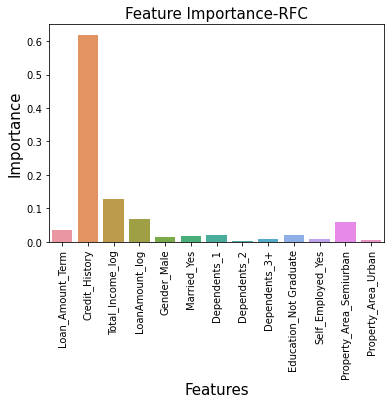

In [50]:
#Retrieving the feature importance using the feature_importances. We can do the same for DT and XGB based models.
#For logistic regression and SVM we can just take a loo to the coeficient magnitude
Feature_Importance=Results['Model'][10].best_estimator_.steps[0][1].feature_importances_ #RFC
#Results['Model'][9].best_estimator_.steps[0][1].feature_importances_ #DT
#Results['Model'][6].best_estimator_.steps[1][1].coef_ #Logreg
#Results['Model'][7].best_estimator_.steps[1][1].coef_ #SVM
#Results['Model'][11].best_estimator_.steps[1][1].feature_importances_ #xgb

plt.xticks(rotation='90')
sns.barplot(x=X.columns, y=Feature_Importance)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importance-RFC', fontsize=15)

By a long shoot, credit history is the feature with more weight, with around 70% of the importance.


##### 3.4  Feature Engineering
We will now do some feature engineering and create new feature to see if we can improve the accuracy of the model. In particular, we are going to create the following additional features:

- Loan Amount to Total Income Ratio. Which percentage of the applicant monthly income is dedicated to pay the loan.
- Equated Monthly Installment (EMI). Monthly loan payment that includes the interest amount. o calculate it, we use the following formula: 
               EMI=B*(r(1+r)^n)/((1+r)^n-1) where B is balance, r montly interest, is the number of payments. We don't know the monthly interest. We will considerer a flat interest of 5% for all the applications.
                                       
                                       
- EMI to Total Income Ratio. Similar to Loan Amount to Total Income Ratio, but using the calculated EMI
- Has Coapplicant?. Boolean variable that just indicates is the application has a coapllicant or not.

In [64]:
#Calculated variable 1: Ratio loan to total_Income
#Convert Loan Amount from k to unit.
loan_train_prepro['Loan_to_income']=np.round(loan_train_prepro['Total_Income'].div(loan_train_prepro['LoanAmount'].mul(1000).div(loan_train_prepro['Loan_Amount_Term'])))
loan_train_prepro['Loan_to_income_log']=np.log(loan_train_prepro['Loan_to_income'])

#Calculated variable 2:Equated Monthly Payment (EMI). Apply log transform to reduce the skewness
#Formula M=B*(r(1+r)^n)/((1+r)^n-1)
#M is your monthly payment.
#B is balance
#r is your monthly interest rate 5%=>  5/12/100
#n is your number of payments (the number of months you will be paying the loan)
ir=0.05
mir=ir/12
loan_train_prepro['EMI']= loan_train_prepro['LoanAmount']*1000*((mir*(1+mir)**loan_train_prepro['Loan_Amount_Term'])/((1+mir)**loan_train_prepro['Loan_Amount_Term']-1))
loan_train_prepro['EMI_log']=np.log(loan_train_prepro['EMI'])

#Calculated variable 3: Ratio Equated Monthly Payment (EMI) to Total_Income.Apply log transform to reduce the skewness
loan_train_prepro['EMI_to_income']=np.round(loan_train_prepro['Total_Income'].div(loan_train_prepro['EMI']))
loan_train_prepro['EMI_to_income_log']=np.log(loan_train_prepro['EMI_to_income'])

#Calculated variable 4: Has codependent
loan_train_prepro['CoApplicant?']=np.where(loan_train_prepro['CoapplicantIncome']>0,1,0)

In [66]:
loan_train_prepro.columns


Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Total_Income',
       'Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y',
       'Loan_to_income', 'Loan_to_income_log', 'EMI', 'EMI_log',
       'EMI_to_income', 'EMI_to_income_log', 'CoApplicant?'],
      dtype='object')

In [67]:
X=loan_train_prepro[['Loan_Amount_Term', 'Credit_History','Total_Income_log', 'LoanAmount_log', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+','Education_Not Graduate', 'Self_Employed_Yes','Property_Area_Semiurban', 'Property_Area_Urban',
       'Loan_to_income_log', 'EMI_log', 'EMI_to_income_log', 'CoApplicant?']].copy()

##### 3.5 Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, no Feature Selection

In [68]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))

--- 9910.2714407444 seconds ---


In [70]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features plus calculated features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original and calculated features.\
                                     Log transform. Gridsearch, No feature selection'] 

In [88]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
18    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
19       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
20       KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
21     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
22        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
23       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   

                                          Features  Best_Score_train  \
0                            All original features           0.80981   
1                            All original features           0.82067   
2                            All original features           0.81940   
3                            All original features           1.00000   
4                            All original features           0.98860   
5                            All original features           0.86193   
6                            All original features           0.80945   
7                            All original features           0.80945   
8                            All original features           0.80149   
9                            All original features           0.80945   
10                           All original features           0.81343   
11                           All original features           0.81307   
12                           All original features           0.80945   
13                           All original features           0.80945   
14                           All original features           0.81325   
15                           All original features           0.80945   
16                           All original features           0.89233   
17                           All original features           0.81977   
18  All original features plus calculated features           0.80927   
19  All original features plus calculated features           0.80945   
20  All original features plus calculated features           0.81306   
21  All original features plus calculated features           0.80945   
22  All original features plus calculated features           0.87134   
23  All original features plus calculated features           0.88075   

    Best_Score_test              Case  \
0           0.80807    Algorithm only   
1           0.80648    Algorithm only   
2           0.76073    Algorithm only   
3           0.69383    Algorithm only   
4           0.74296    Algorithm only   
5           0.80325    Algorithm only   
6           0.80945        Gridsearch   
7           0.80945        Gridsearch   
8           0.78339        Gridsearch   
9           0.80945        Gridsearch   
10          0.81107        Gridsearch   
11          0.81107        Gridsea

Some improvement of RF and XGB based models if we compared against the accuracy obtained with the Gridsearch without calculated features. No improvement in the cases of logistic regression and SVM.

Let´s take a look to the feature importances:

Text(0.5, 1.0, 'Feature Importance-XGBC')

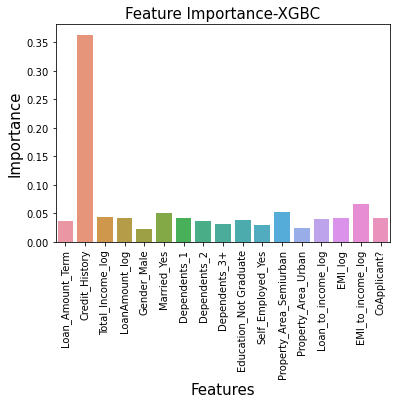

In [94]:
#Retrieving the feature importance using the feature_importances. We can do the same for DT and XGB based models.
#For logistic regression and SVM we can just take a loo to the coeficient magnitude
#Feature_Importance=Results['Model'][22].best_estimator_.steps[0][1].feature_importances_ #RF
Feature_Importance=Results['Model'][23].best_estimator_.steps[1][1].feature_importances_ #XGBC

plt.xticks(rotation='90')
sns.barplot(x=X.columns, y=Feature_Importance)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importance-XGBC', fontsize=15)

Checking the feature importance of the XGBC based model, we see that while Credit History appears as the most important feature, some of the calculated features such as the EMI to income log also are contributing to the model prediction capability. 

##### 3.6 Feature selection

Let's take one step further and perform a feature selection. "The objective of variable selection is three-fold: improving the prediction performance of the predictors, providing faster and more cost-effective predictors, and providing a better understanding of the underlying process that generated the data.*" (*from An Introduction to Variable and Feature Selection, Journal of Machine Learning Research 3 (2003) 1157-1182)

We will use the following methods of feature selection:
- Univariate feature selection, which works by selecting the best features based on univariate statistical tests.
- Selection from model, which is a model based selection which uses coeficient or feature importance attributes of the estimators.
- Recursive feature elimination, that selects features by recursively considering smaller and smaller sets of features based on feature importances / coefficients
- Exhaustive Feature Selection, whichis a wrapper approach for brute-force evaluation of feature subsets. . For instance, if the classifier is a logistic regression and the dataset consists of 4 features, the alogorithm will evaluate all 15 feature combinations.

In [97]:
#Creating a DataFrame to store the results of the different FS methodsl
Features_Rank=pd.DataFrame(index=X.columns.values)

##### 3.6.1 Feature selection method: SelectKBest

In [98]:
#a)Feature selection method: SelectKBest
#Univariate feature selection works by selecting the best features based on univariate statistical tests
    #For regression: f_regression, mutual_info_regression
    #For classification: chi2, f_classif, mutual_info_classif
kbest_test={'chi2': chi2,'f_classif': f_classif,'mutual_info_classif':mutual_info_classif}
for key,value in kbest_test.items():
    selector = SelectKBest(value)
    selector.fit_transform(X, y)
    Features_Rank[key]=selector.get_support()

In [99]:
Features_Rank

chi2  f_classif  mutual_info_classif
Loan_Amount_Term          True      False                 True
Credit_History            True       True                 True
Total_Income_log         False      False                False
LoanAmount_log           False       True                False
Gender_Male              False      False                False
Married_Yes               True       True                 True
Dependents_1              True       True                 True
Dependents_2              True       True                False
Dependents_3+             True      False                 True
Education_Not Graduate    True       True                False
Self_Employed_Yes        False      False                False
Property_Area_Semiurban   True       True                False
Property_Area_Urban       True       True                 True
Loan_to_income_log       False      False                 True
EMI_log                  False      False                 True
EMI_to_income_log        False       True                 True
CoApplicant?              True       True                 True

##### 3.6.2 Feature selection method: SelectFromModel

In [100]:
alg1=LogisticRegression()
alg2= SVC(kernel='linear')#Only linear has coef_ attribute
#alg3=KNeighborsClassifier() No coefficient in this model
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()

alglist= [alg1,alg2,alg4,alg5,alg6]

for alg,name in zip(alglist,('Logreg','SVM', 'DTree','RF','XGB')):
    selector = SelectFromModel(alg)
    selector.fit(X, y)
    Features_Rank['SelectFromModel_'+ name]=selector.get_support()

In [101]:
Features_Rank

chi2  f_classif  mutual_info_classif  \
Loan_Amount_Term          True      False                 True   
Credit_History            True       True                 True   
Total_Income_log         False      False                False   
LoanAmount_log           False       True                False   
Gender_Male              False      False                False   
Married_Yes               True       True                 True   
Dependents_1              True       True                 True   
Dependents_2              True       True                False   
Dependents_3+             True      False                 True   
Education_Not Graduate    True       True                False   
Self_Employed_Yes        False      False                False   
Property_Area_Semiurban   True       True                False   
Property_Area_Urban       True       True                 True   
Loan_to_income_log       False      False                 True   
EMI_log                  False      False                 True   
EMI_to_income_log        False       True                 True   
CoApplicant?              True       True                 True   

                         SelectFromModel_Logreg  SelectFromModel_SVM  \
Loan_Amount_Term                          False                False   
Credit_History                             True                 True   
Total_Income_log                          False                False   
LoanAmount_log                            False                False   
Gender_Male                               False                False   
Married_Yes                                True                False   
Dependents_1                              False                False   
Dependents_2                              False                False   
Dependents_3+                             False                False   
Education_Not Graduate                    False                False   
Self_Employed_Yes                         False                False   
Property_Area_Semiurban                    True                False   
Property_Area_Urban                       False                False   
Loan_to_income_log                        False                False   
EMI_log                                    True                 True   
EMI_to_income_log                         False                False   
CoApplicant?                              False                False   

                         SelectFromModel_DTree  SelectFromModel_RF  \
Loan_Amount_Term                         False               False   
Credit_History                            True                True   
Total_Income_log                          True                True   
LoanAmount_log                            True                True   
Gender_Male                              False               False   
Married_Yes                              False               False   
Dependents_1                             False               False   
Dependents_2                             False               False   
Dependents_3+                            False               False   
Education_Not Graduate                   False               False   
Self_Employed_Yes                        False               False   
Property_Area_Semiurban                  False               False   
Property_Area_Urban                      False               False   
Loan_to_income_log                       False                True   
EMI_log                                   True                True   
EMI_to_income_log                        False                True   
CoApplicant?                             False               False   

                         SelectFromModel_XGB  
Loan_Amount_Term                       False  
Credit_History                          True  
Total_Income_log                       False  
LoanAmount_log                         False  
Gender_Male                            False

##### 3.6.3 Feature selection method: RFECV (plus estimation of the accuracyy of the model with the selected features)

In [103]:
alg1=LogisticRegression()
alg2= SVC()
alg3=KNeighborsClassifier()
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()


kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42) 

scaler=StandardScaler()

pipe1 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg1, step=1,scoring='accuracy'))])
pipe2 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg2, step=1,scoring='accuracy'))])
#pipe3 = Pipeline([('std', StandardScaler()),('alg',alg3)])#No RFE in KNN
pipe4 = Pipeline([('selector', RFECV(alg4, step=1,scoring='accuracy'))])
pipe5 = Pipeline([('selector', RFECV(alg5, step=1,scoring='accuracy'))])
pipe6 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg6, step=1,scoring='accuracy'))])

param_grid1 = {'selector__estimator__solver':['lbfgs', 'liblinear'],'selector__estimator__penalty': ['l2'],'selector__estimator__C': [0.001,0.01,0.1,1,10,100]}
param_grid2 = {'selector__estimator__kernel': ['linear'], 'selector__estimator__C': [0.001,0.01,0.1,1,10,100],
                'selector__estimator__gamma': np.power(10., np.arange(-5, 0)),'selector__estimator__decision_function_shape' : ['ovo', 'ovr']}
#param_grid3 = {'alg__n_neighbors': list(range(1, 10)),'alg__p': [1, 2]}
param_grid4 = {'selector__estimator__max_depth': list(range(1, 10)) + [None],'selector__estimator__criterion': ['gini', 'entropy']}
param_grid5 = {'selector__estimator__max_depth': list(range(1, 20, 2)), 'selector__estimator__n_estimators': 
    list(range(1, 200, 20))}
param_grid6 = {'selector__estimator__subsample': np.arange(.05, 1, .05),
                  'selector__estimator__max_depth': np.arange(3,20,1),
                  'selector__estimator__colsample_bytree': np.arange(.1,1.05,.05)}

pipelist= [pipe1,pipe2,pipe4,pipe5,pipe6]
paramlist=[param_grid1,param_grid2,param_grid4,param_grid5,param_grid6]

In [104]:
start_time = time.time()
for i,j,k in zip(pipelist,paramlist,('Logreg','SVC','DTree','RF','XGB')):
    rgrid_rfe = RandomizedSearchCV(i, j, cv=kf,n_jobs=-1,scoring='accuracy',refit=True)
    rgrid_rfe .fit(X,y)    
    if k in ('DTree','RF'):
        selected_features=rgrid_rfe.best_estimator_.steps[0][1].get_support()
        Features_Rank['RFECV_'+ k]=selected_features
    else:
        selected_features=rgrid_rfe.best_estimator_.steps[1][1].get_support()
        Features_Rank['RFECV_'+ k]=selected_features     
    Results.loc[len(Results)] = [k, rgrid_rfe,selected_features,'-',rgrid_rfe.best_score_,'RFECV','Original and calculated features.\
                                     Log transform. REFCV, Recursive Feature Elimination'] 
print("--- %s seconds ---" % (time.time() - start_time))

--- 1012.7145311832428 seconds ---


In [105]:
Features_Rank

chi2  f_classif  mutual_info_classif  \
Loan_Amount_Term          True      False                 True   
Credit_History            True       True                 True   
Total_Income_log         False      False                False   
LoanAmount_log           False       True                False   
Gender_Male              False      False                False   
Married_Yes               True       True                 True   
Dependents_1              True       True                 True   
Dependents_2              True       True                False   
Dependents_3+             True      False                 True   
Education_Not Graduate    True       True                False   
Self_Employed_Yes        False      False                False   
Property_Area_Semiurban   True       True                False   
Property_Area_Urban       True       True                 True   
Loan_to_income_log       False      False                 True   
EMI_log                  False      False                 True   
EMI_to_income_log        False       True                 True   
CoApplicant?              True       True                 True   

                         SelectFromModel_Logreg  SelectFromModel_SVM  \
Loan_Amount_Term                          False                False   
Credit_History                             True                 True   
Total_Income_log                          False                False   
LoanAmount_log                            False                False   
Gender_Male                               False                False   
Married_Yes                                True                False   
Dependents_1                              False                False   
Dependents_2                              False                False   
Dependents_3+                             False                False   
Education_Not Graduate                    False                False   
Self_Employed_Yes                         False                False   
Property_Area_Semiurban                    True                False   
Property_Area_Urban                       False                False   
Loan_to_income_log                        False                False   
EMI_log                                    True                 True   
EMI_to_income_log                         False                False   
CoApplicant?                              False                False   

                         SelectFromModel_DTree  SelectFromModel_RF  \
Loan_Amount_Term                         False               False   
Credit_History                            True                True   
Total_Income_log                          True                True   
LoanAmount_log                            True                True   
Gender_Male                              False               False   
Married_Yes                              False               False   
Dependents_1                             False               False   
Dependents_2                             False               False   
Dependents_3+                            False               False   
Education_Not Graduate                   False               False   
Self_Employed_Yes                        False               False   
Property_Area_Semiurban                  False               False   
Property_Area_Urban                      False               False   
Loan_to_income_log                       False                True   
EMI_log                                   True                True   
EMI_to_income_log                        False                True   
CoApplicant?                             False               False   

                         SelectFromModel_XGB  RFECV_Logreg  RFECV_SVC  \
Loan_Amount_Term                       False         False      False   
Credit_History                          True          True       True   
Total_Income_log                       False         False  

In [106]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
18    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
19       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
20       KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
21     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
22        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
23       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
24    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
25       SVC  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
26     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
27        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
28       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   

                                             Features Best_Score_train  \
0                               All original features          0.80981   
1                               All original features          0.82067   
2                               All original features          0.81940   
3                               All original features          1.00000   
4                               All original features          0.98860   
5                               All original features          0.86193   
6                               All original features          0.80945   
7                               All original features          0.80945   
8                               All original features          0.80149   
9                               All original features          0.80945   
10                              All original features          0.81343   
11                              All original features          0.81307   
12                              All original features          0.80945   
13                              All original features          0.80945   
14                              All original features          0.81325   
15                              All original features          0.80945   
16                              All original features          0.89233   
17                              All original features          0.81977   
18     All original features plus calculated features          0.80927   
19     All original features plus calculated features          0.80945   
20     All original features plus calculated features          0.81306   
21     All original features plus calculated features          0.80945   
22     All original features plus calculated features          0.87134   
23     All original features plus calculated features          0.88075   
24  [False, True, False, False, False, False, Fals...                -   
25  [False, True, False, False, False, False, Fals...               

##### 3.6.4 Feature selection method: Exhaustive Feature Selection (EFS) 
Let's now calculate  the accuracy of a model using just the features selected by the EFS method. Since EFS calculate all the possible combinations of the maximum numbers of features selected, it's computationally expensive so we will pre-select the features that have resulted
more significant so far.

In [110]:
X_=X[['Credit_History','Total_Income_log','LoanAmount_log','Married_Yes','Property_Area_Semiurban','Loan_to_income_log', \
      'EMI_log','EMI_to_income_log','CoApplicant?']]
Features_Rank_=pd.DataFrame(index=X_.columns.values)

In [111]:
start_time = time.time()
for i,j in zip(alglist,('Logreg','SVM','DTree','RF','XGB')):
    efs=EFS(i, min_features=1,max_features=5,scoring='accuracy',
            clone_estimator=False,print_progress=False,cv=5,n_jobs=1)
    efs=efs.fit(X_,y)
    selected_features= np.zeros(X_.shape[1], bool)#Size of X, all false
    selected_features[np.array(efs.best_idx_)]=True #to fill missing index with NaN
    Features_Rank_['EFS_'+ j]=selected_features
print("--- %s seconds ---" % (time.time() - start_time))   

--- 118.96814632415771 seconds ---


In [112]:
Features_Rank=pd.concat([Features_Rank,Features_Rank_],axis=1)

In [130]:
Features_Rank.sum(axis=1)

Loan_Amount_Term           2.00000
Credit_History            18.00000
Total_Income_log           3.00000
LoanAmount_log             4.00000
Gender_Male                0.00000
Married_Yes                5.00000
Dependents_1               3.00000
Dependents_2               2.00000
Dependents_3+              2.00000
Education_Not Graduate     2.00000
Self_Employed_Yes          0.00000
Property_Area_Semiurban    4.00000
Property_Area_Urban        3.00000
Loan_to_income_log         3.00000
EMI_log                    6.00000
EMI_to_income_log          6.00000
CoApplicant?               3.00000
dtype: float64

We can see that the univariate selection methods tend to select much more features, while the other methods are more restrictive.
Credit history is selected by all the methods, proving the importance of this feature. We also see that "CoApplicant?" feature we have created has certain importance and in fact has been selected by six of the seven exhaustive feature selection we have performed.

##### 3.7  Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, and EFS

In [153]:
alglist= [alg1,alg2,alg4,alg5,alg6]

#Pipelines for GridSearch
pipegrid1 = Pipeline([('std', StandardScaler()),
                  ('alg1', alg1)])
pipegrid2 = Pipeline([('std', StandardScaler()),
                  ('alg2', alg2)])
#pipegrid3 = Pipeline([('std', StandardScaler()),
               #   ('alg3', alg3)])
pipegrid4=Pipeline([('alg4', alg4)])
pipegrid5= Pipeline([('alg5', alg5)])  
pipegrid6 = Pipeline([('std', StandardScaler()),
                     ('alg6', alg6)])
#Hyper paramaeter grids for the gridsearch.    
param_grid1 = {'alg1__solver':['lbfgs', 'liblinear'],'alg1__penalty': ['l2'],'alg1__C': [0.001,0.01,0.1,1,10,100]} #np.power(10., np.arange(-4, 4)
param_grid2 = {'alg2__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'alg2__C': [0.001,0.01,0.1,1,10,100],
                'alg2__gamma': np.power(10., np.arange(-5, 0)),'alg2__decision_function_shape' : ['ovo', 'ovr']}
#param_grid3 = {'alg3__n_neighbors': list(range(1, 10)),'alg3__p': [1, 2]}
param_grid4 = {'alg4__max_depth': list(range(1, 10)) + [None],'alg4__criterion': ['gini', 'entropy']}
param_grid5 = {'alg5__max_depth': list(range(1, 20, 2)), 'alg5__n_estimators': 
    list(range(1, 200, 20))}
param_grid6 = {'alg6__subsample': np.arange(.05, 1, .05),
                  'alg6__max_depth': np.arange(3,20,1),
                  'alg6__colsample_bytree': np.arange(.1,1.05,.05)}

pipegridlist= [pipegrid1,pipegrid2,pipegrid4,pipegrid5,pipegrid6]
paramgridlist=[param_grid1,param_grid2,param_grid4,param_grid5,param_grid6]

In [154]:
##Gridsearch for EFS 
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,['Logreg','SVM', 'DTree','RF','XGB']):
    X_fs=X_[Features_Rank_.index[Features_Rank_['EFS_'+ k]]]
    rgrid = GridSearchCV(i, j, cv=kf,return_train_score='True',scoring='accuracy',refit=True)
    rgrid.fit(X_fs,y)
    Gridsearch[k]= rgrid
print("--- %s seconds ---" % (time.time() - start_time))



--- 1781.8421392440796 seconds ---


In [155]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'EFS',
                                    gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'EFS and Gridsearch',\
                                     'Original and calculated features.Log transform. EFS plus Gridsearch'] 

In [156]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
18    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
19       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
20       KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
21     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
22        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
23       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
24    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
25       SVC  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
26     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
27        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
28       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
29    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
30       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
31     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
32        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
33       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   

                                             Features Best_Score_train  \
0                               All original features          0.80981   
1                               All original features          0.82067   
2                               All original features          0.81940   
3                               All original features          1.00000   
4                               All original features          0.98860   
5                               All original features          0.86193   
6                               All original features          0.80945   
7                               All original features          0.80945   
8                               All original features          0.80149   
9                               All original features          0.80945   
10                              All original features          0.81343   
11                              All original features          0.81307   
12                              All original features          0.80945   
13                              All original features          0.80945   
14                              All original features          0.81325   
15                              All original features          0.80945   
16                              All original features          0.89233   
17                              All original features          0.81977   
18     All original features plus calculated features          0.80927   
19     All original features plus calculated features          0.80945   
20     All original features plus calculated features          0.81306   
21     All original features 

In [157]:
file_path='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/results/'

Results.to_pickle(file_path+ 'Results.pkl')
Features_Rank.to_pickle(file_path+ 'Features_Rank.pkl')

##### 3.8 Model results analysis

Now we have all the accuracy scoring for all the models, we can take a look and compare the results:
- Full list of results:

In [158]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
18    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
19       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
20       KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
21     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
22        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
23       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
24    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
25       SVC  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
26     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
27        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
28       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
29    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
30       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
31     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
32        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
33       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   

                                             Features Best_Score_train  \
0                               All original features          0.80981   
1                               All original features          0.82067   
2                               All original features          0.81940   
3                               All original features          1.00000   
4                               All original features          0.98860   
5                               All original features          0.86193   
6                               All original features          0.80945   
7                               All original features          0.80945   
8                               All original features          0.80149   
9                               All original features          0.80945   
10                              All original features          0.81343   
11                              All original features          0.81307   
12                              All original features          0.80945   
13                              All original features          0.80945   
14                              All original features          0.81325   
15                              All original features          0.80945   
16                              All original features          0.89233   
17                              All original features          0.81977   
18     All original features plus calculated features          0.80927   
19     All original features plus calculated features          0.80945   
20     All original features plus calculated features          0.81306   
21     All original features 

Features selection has not helped to improve our best accuracy so far. Is worth mentioning that the Credit History has so inportance that a model- only considering Credit History accuracy is comparable to a model using more features.

- Top 2 models of each algorithm:

In [163]:
#Select Top 2 of each algorithm
Results[['Algorithm','Best_Score_test','Case','Features']].groupby('Algorithm',sort=False).apply(lambda x:x.sort_values(by='Best_Score_test',ascending=False).head(2))

Algorithm  Best_Score_test                Case  \
Algorithm                                                     
Logreg    6     Logreg          0.80945          Gridsearch   
          12    Logreg          0.80945    Randomizedsearch   
SVM       7        SVM          0.80945          Gridsearch   
          13       SVM          0.80945    Randomizedsearch   
KNN       20       KNN          0.78502          Gridsearch   
          8        KNN          0.78339          Gridsearch   
DTree     9      DTree          0.80945          Gridsearch   
          15     DTree          0.80945    Randomizedsearch   
RF        22        RF          0.81433          Gridsearch   
          32        RF          0.81270  EFS and Gridsearch   
XGB       23       XGB          0.82085          Gridsearch   
          11       XGB          0.81107          Gridsearch   
SVC       25       SVC          0.80945               RFECV   

                                                       Features  
Algorithm                                                        
Logreg    6                               All original features  
          12                              All original features  
SVM       7                               All original features  
          13                              All original features  
KNN       20     All original features plus calculated features  
          8                               All original features  
DTree     9                               All original features  
          15                              All original features  
RF        22     All original features plus calculated features  
          32                                                EFS  
XGB       23     All original features plus calculated features  
          11                              All original features  
SVC       25  [False, True, False, False, False, False, Fals...

In [161]:
Results

Algorithm                                              Model  \
0     Logreg  {'fit_time': [0.0049860477447509766, 0.0049884...   
1        SVM  {'fit_time': [0.03795957565307617, 0.038833379...   
2        KNN  {'fit_time': [0.0039904117584228516, 0.0039887...   
3      DTree  {'fit_time': [0.004987239837646484, 0.00597834...   
4         RF  {'fit_time': [0.01794910430908203, 0.018945217...   
5        XGB  {'fit_time': [0.04983019828796387, 0.053163528...   
6     Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
7        SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
8        KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
9      DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
10        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
11       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
12    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
13       SVM  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
14       KNN  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
15     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
16        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
17       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
18    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
19       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
20       KNN  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
21     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
22        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
23       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
24    Logreg  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
25       SVC  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
26     DTree  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
27        RF  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
28       XGB  RandomizedSearchCV(cv=StratifiedKFold(n_splits...   
29    Logreg  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
30       SVM  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
31     DTree  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
32        RF  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   
33       XGB  GridSearchCV(cv=StratifiedKFold(n_splits=10, r...   

                                             Features Best_Score_train  \
0                               All original features          0.80981   
1                               All original features          0.82067   
2                               All original features          0.81940   
3                               All original features          1.00000   
4                               All original features          0.98860   
5                               All original features          0.86193   
6                               All original features          0.80945   
7                               All original features          0.80945   
8                               All original features          0.80149   
9                               All original features          0.80945   
10                              All original features          0.81343   
11                              All original features          0.81307   
12                              All original features          0.80945   
13                              All original features          0.80945   
14                              All original features          0.81325   
15                              All original features          0.80945   
16                              All original features          0.89233   
17                              All original features          0.81977   
18     All original features plus calculated features          0.80927   
19     All original features plus calculated features          0.80945   
20     All original features plus calculated features          0.81306   
21     All original features 

- Top 10:

In [164]:
Results[['Algorithm','Best_Score_test','Case','Features']].sort_values(by='Best_Score_test',ascending=False).head(10)

Algorithm  Best_Score_test                Case  \
23       XGB          0.82085          Gridsearch   
22        RF          0.81433          Gridsearch   
32        RF          0.81270  EFS and Gridsearch   
10        RF          0.81107          Gridsearch   
27        RF          0.81107               RFECV   
11       XGB          0.81107          Gridsearch   
6     Logreg          0.80945          Gridsearch   
15     DTree          0.80945    Randomizedsearch   
21     DTree          0.80945          Gridsearch   
24    Logreg          0.80945               RFECV   

                                             Features  
23     All original features plus calculated features  
22     All original features plus calculated features  
32                                                EFS  
10                              All original features  
27  [False, True, True, True, False, False, False,...  
11                              All original features  
6                               All original features  
15                              All original features  
21     All original features plus calculated features  
24  [False, True, False, False, False, False, Fals...

Top model is based in XGB tunned with a Gridsearch using some of the calculated features. There is no a huge difference between the accuracy scoring of the top 1 and top 10, though. And as mention, model using just one featrue (Credit History) perform similarly to models with more features.

##### 3.8 Resampling
Since the dataset is imbalanced (70% of laon approved vs 30% not approved), we will explore several methods of resampling.

In [165]:
#Under-sampling the majority class(es).
##Randomunder sampling
rus=RandomUnderSampler(random_state=2)
##Tomek links
tl = TomekLinks( ratio='majority')
#Over-sampling the minority class.
##Random Over Sampling
ros=RandomOverSampler(random_state=2,sampling_strategy='minority')
sm = SMOTE(random_state=2)
##Synthetic Minority Oversampling Technique (SMOTE)
#Combining over- and under-sampling.
#SMOTE Tomek
smt = SMOTETomek(ratio='auto')

In [166]:
Accuracy_resampling=pd.DataFrame(index=['Logreg','SVM', 'KNN', 'DTree','RF','XGB'])
alglist= [alg1,alg2,alg3,alg4,alg5,alg6]
scores=[]

In [167]:
for i in alglist:
    scores.append(cross_val_score(i, X.values, y, cv=kf).mean())
Accuracy_resampling['Baseline']=np.array(scores)

In [168]:
for i,j in zip(['rus','tl','ros','sm','smt'],[rus,tl,ros,sm,smt]):
    scores=[]
    for k in alglist:
        pipeline = Imb_pipeline(steps=[('res', j), ('clf', k)])
        scores.append(cross_val_score(pipeline, X.values, y, cv=kf).mean())
    Accuracy_resampling[i]=np.array(scores)

In [169]:
Accuracy_resampling

Baseline     rus      tl     ros      sm     smt
Logreg   0.80643 0.74772 0.80315 0.75285 0.75131 0.74634
SVM      0.79178 0.75095 0.79173 0.77380 0.77877 0.77047
KNN      0.75412 0.65967 0.73794 0.66950 0.62196 0.65004
DTree    0.68103 0.62704 0.67770 0.71678 0.70023 0.70546
RF       0.76089 0.64798 0.75751 0.72170 0.72667 0.72313
XGB      0.80156 0.74127 0.79833 0.75904 0.79511 0.79024

We don't obtain an accuracy increase with any of the resamplimg method. To see what is happening, we can take a look to the confussion matrix, and compare the results without resampling and resampling:

In [170]:
y_pred=cross_val_predict(LogisticRegression(), X, y, cv=kf)
pipeline = Imb_pipeline(steps=[('res', sm), ('clf', LogisticRegression())])
y_pred_res=cross_val_predict(pipeline, X, y, cv=kf)

In [171]:
confussion_matrix=pd.crosstab(y,y_pred,rownames=['True'], colnames=['Predicted'], margins=True)
confussion_matrix_res=pd.crosstab(y,y_pred_res,rownames=['True'], colnames=['Predicted'], margins=True)

confussion_matrix

Predicted   0    1  All
True                   
0          82  110  192
1           9  413  422
All        91  523  614

In [172]:
confussion_matrix_res

Predicted    0    1  All
True                    
0          105   87  192
1           66  356  422
All        171  443  614

We appreciate a increase in the succesful prediction of the minority class, but this comes in detrieemnt of the prediction of the majority class. As a result of this trade-off, no increase in the accuracy is achieved. If for some reason we wanted to improve the prediction of the minority class, resampling would be an option. Nevertheless, we will execute a gridsearch for an undersamples with tome links data set: